# Plan : 

- Represent states.
- Build a class for the game :
    - Reset.
    - Play a move : Take an action.
    - Play a game.
    - Is done : check if game is done.
 
- Build a class for the agent :
    - Value function update.
   
 

# Outlines : 
- Utilities.
    1. Generating a grid.
    2. Drawing a grid.
    3. 
- Classes.
- Training.
- Experiences.
- Testing the Agent vs Human Agent.


   
 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# store lenght of the grid here
LENGTH = 3

# Generating a random grid

In [3]:
def generate_grid():
    grid = np.zeros((LENGTH, LENGTH))
    for i in range(LENGTH):
        for j in range(LENGTH):
            grid[i,j] = np.random.choice([-1, 0, 1])
    return grid

In [ ]:
print(generate_grid())

[[ 1.  0.  0.]
 [-1.  0.  0.]
 [ 1. -1.  1.]]


# Drawing a grid 

In [4]:
def draw_grid(grid):
        for i in range(LENGTH):
            print("-------------")
            for j in range(LENGTH):
                #print(" ", end='')
                if j == 0:
                    if grid[i, j] == -1:
                        print("| x |", end='')
                    elif grid[i, j] == 1:
                        print("| o |", end='')
                    else:
                        print("|   |" ,end='')
                else:
                    if grid[i, j] == -1:
                        print(" x |", end='')
                    elif grid[i, j] == 1:
                        print(" o |", end='')
                    else:
                        print("   |" ,end='')
                    
            print("")
        print("-------------")

In [5]:
def print_grid_info(grid):
    s = "Grid state = "
    for i in range(3):
        for j in range(3):
            if grid[i,j] == -1:
                s_ij = "3^" + str(3*i+j) + " +"
                s = s + s_ij
            elif grid[i,j] == 1:
                s_ij = "2*3^" + str(3*i+j) + " +"
                s = s + s_ij
            elif grid[i,j] ==0:
                s_ij = "0*3^" + str(3*i+j) + " +"
                s = s + s_ij


    s = s[:-1]
    print(s)
    #return s

In [ ]:
grid = generate_grid()
draw_grid(grid)
print_grid_info(grid)

-------------
| o |   | o |
-------------
|   | x | o |
-------------
| x | x | x |
-------------
Grid state = 2*3^0 +0*3^1 +2*3^2 +0*3^3 +3^4 +2*3^5 +3^6 +3^7 +3^8 


## Respresenting states

In [6]:
def get_state(grid):
        # returns the current state, represented as int
        h = 0
        k = 0
        for i in range(LENGTH):
            for j in range(LENGTH):
                if grid[i, j] == 0:
                    v = 0
                elif grid[i, j] == -1:
                    v = 1
                elif grid[i, j] == 1:
                    v = 2
                h += v * (3 ** k)
                k += 1
        return h

## Game Ended or not

In [7]:
def get_winner_and_game_over(grid):
        winner = None
        # check rows
        for i in range(LENGTH):
            for player in (-1, 1):
                if grid[i].sum() == player * LENGTH:
                    winner = player
                    return winner, True
                
        # check columns
        for i in range(LENGTH):
            for player in (-1, 1):
                if grid[:, i].sum() == player * LENGTH:
                    winner = player
                    return winner, True
                
        # check diagonals
        for player in (-1, 1):
            if np.trace(grid) == player * LENGTH:
                winner = player
                return winner, True
            if np.trace(np.fliplr(grid)) == player * LENGTH:
                winner = player
                return winner, True

        # check if draw
        if np.all(grid != 0) == True:
            # winner stays None
            winner = None
            return winner, True

        # game is not over
        winner = None
        return winner, False

In [ ]:
grid = generate_grid()
draw_grid(grid)
state = get_state(grid)
print('state: ', state)
winner, over = get_winner_and_game_over(grid)
print('winner:', winner ,', over:', over)

-------------
| o | x | x |
-------------
|   |   |   |
-------------
|   |   | x |
-------------
state:  6575
winner: None , over: False


## Conclusion 

Each grid is mapped to an integer in [0, 19683 )

3 ** 9 = 19683

## Actions

Taking an action corresponds to placing a symbol X or O on the board.




# Environment Class

In [8]:
# build environment class
class TicTacToe:
    def __init__(self):
        self.grid = np.zeros((LENGTH, LENGTH))
        self.x = -1  # represents an x on the board
        self.o = 1  # represnt an o on the board
        self.ended = False
        self.winner = None
        self.num_states = 3 ** (LENGTH * LENGTH)

    # reset the board after the game is finished    
    def reset(self):
        self.grid = np.zeros((LENGTH, LENGTH))
        self.ended = False
        self.winner = None

    # make a move
    def move(self, position, xo):
        assert xo in [self.x, self.o], "Move not allowed"
        assert self.is_empty(position[0], position[1]), "Position occupied"
        #assert not self.ended, "Game is Over"
        self.grid[position] = xo
        self.game_over()

    def is_empty(self, i, j):
        return self.grid[i, j] == 0

    def game_over(self):
        self.winner, self.ended = get_winner_and_game_over(self.grid)
        return self.ended
                     
    def get_winner(self):
        self.game_over()
        return self.winner

    def draw_board(self):
        draw_grid(self.grid)

    def reward(self, sym):
        # no reward until game is over
        if not self.game_over():
            return 0
        # if we get here, game is over
        if self.winner == sym:
            return 2
        elif self.winner == -sym:
            return -1
        else:
            return 0

    def get_state(self):
        return get_state(self.grid)

# Agents Classes

### Random Agent 

In [9]:
# build the agent class
#NOTE: I could have used the agent class with a large epsilon but I duplicated it for explicity
class RandomAgent:
    def __init__(self):
        self.state_history = []
        self.eps = 0 # only here to conform to the agent class API

    def set_symbol(self, sym):
        self.sym = sym

    def take_optimal_action(self, env): # only here to conform to the agent class API
        self.take_action(env)

    def take_action(self, env):
        possible_moves = []
        for i in range(LENGTH):
            for j in range(LENGTH):
                if env.is_empty(i, j):
                    possible_moves.append((i, j))
        idx = np.random.choice(len(possible_moves))
        next_move = possible_moves[idx]
        env.move(next_move, self.sym)
        return next_move
          
    def update(self): # only here to conform to the agent class API
        self.state_histoy = []
    def update_epsilon(self, decay):
        pass

### Principal Agent

In [10]:
# build the agent class
class Agent:
    def __init__(self, eps=0.1, alpha=0.5, gamma=0.95):
        self.eps = eps
        self.alpha = alpha
        self.gamma = gamma
        self.resetQ()
        self.state_history = []
        
    def resetQ(self):
        # Q Matrix
        # Q(state, action)
        # state represented by its hash
        # action represented by indices of next action (i, j)
        # action index = i + 3j
        self.Q = np.zeros((LENGTH**(LENGTH*LENGTH), LENGTH*LENGTH))# shape: (19683, 9)

    def set_symbol(self, sym):
        self.sym = sym


    def get_action(self, env):
        '''
        returns greedy action as tuple (i,j)
        '''
        pos2value = {}
        state = env.get_state()
        possible_actions = []
        for i in range(LENGTH):
            for j in range(LENGTH):
                if env.is_empty(i,j):
                    possible_actions.append((i,j))
                    pos2value[(i,j)] = self.Q[state, i+3*j] 
                    
        q_values = [self.Q[state, action[0]+3*action[1]] for action in possible_actions]
        best_q_value = np.max(q_values)
        best_q_value_indices = np.argwhere(np.array(q_values) == best_q_value)
        best_q_value_index = np.random.choice(best_q_value_indices.flatten())
        best_move = possible_actions[best_q_value_index]         
        return best_move, pos2value
    
    def take_optimal_action(self, env):
        best_move, _ = self.get_action(env)
        env.move(best_move, self.sym)
        return best_move

    def take_action(self, env):
        # choose an action based on epsilon-greedy strategy
        r = np.random.rand()
        if r < self.eps:
            possible_moves = []
            for i in range(LENGTH):
                for j in range(LENGTH):
                    if env.is_empty(i, j):
                        possible_moves.append((i, j))
            idx = np.random.choice(len(possible_moves))
            next_move = possible_moves[idx]
            env.move(next_move, self.sym)
        else:
            next_move = self.take_optimal_action(env)
        return next_move
        

    def update(self):#, env, state, action, next_state):
        final_state, final_action, reward, _ = self.state_history[-1]
        self.Q[final_state, final_action] = reward
        prev_state = final_state
        for state, action, reward, _ in reversed(self.state_history):
            if state != final_state:
                self.Q[state, action] += self.alpha * (reward + self.gamma * np.max(self.Q[prev_state]) - self.Q[state, action])
                prev_state = state
        self.state_history = []
        
    def update_epsilon(self, decay):
        self.eps = max(self.eps*decay, 0.1)
             

### Human Agent

In [11]:
class Human:
    def __init__(self):
        pass
    def set_symbol(self, sym):
        self.sym = sym
        self.state_history = []
        
    def take_action(self, env):
        while True:
            # break if we make an legal move
            move = input('Enter the coordinates i,j for your next move (i,j=0..2)')
            i, j = move.split(',')
            i = int(i)
            j = int(j)
            if env.is_empty(i, j):
                env.grid[i,j] = self.sym
                break
                
    def take_optimal_action(self, env):
        self.take_action(env)

    def update(self):
        self.state_history = []

    def update_state_history(self, s):
        self.state_history = []

# Playing the game


## Agent vs Agent function
Function to play one episode of tic-tac-toe. Returns reward of player 1 and player 2.

In [12]:
def play_game(p1, p2, env, draw=False):
    # loops until the game is over
    current_player = None
    previous_action = None
    while not env.game_over():
        # alternate between players
        # p1 always start first
        if current_player == p1:
            current_player = p2
            previous_player = p1
        else :
            current_player = p1
            previous_player = p2

        # draw the board before the user who wants to see it makes a move
        if draw:
            if draw == 1 and current_player == p1:
                env.draw_board()
            if draw == 2 and current_player == p2:
                env.draw_board()
           
        # get current state
        state = env.get_state()
        # current player makes a move
        move = current_player.take_action(env)
        action = move[0] + 3 * move[1]

        # get next state
        next_state = env.get_state()
        
        reward = env.reward(current_player.sym)
        
        current_player.state_history.append((state, action, reward, next_state))
        
        if env.game_over():
            previous_player_reward = env.reward(previous_player.sym)
            s, a, r, ns = previous_player.state_history[-1]
            previous_player.state_history[-1] = (s, a, previous_player_reward, ns)
            current_player.update()
            previous_player.update()
                
        previous_action = action
        previous_state = state

    if draw:
        env.draw_board()
        
    reward1 = env.reward(p1.sym)
    reward2 = env.reward(p2.sym)
    return reward1, reward2


In [13]:
def test_agent_optimal_game(p1, p2, env, draw=False):
    # loops until the game is over
    current_player = None
    while not env.game_over():
        # alternate between players
        # p1 always start first
        if current_player == p1:
            current_player = p2
            previous_player = p1
        else :
            current_player = p1
            previous_player = p2

        # draw the board before the user who wants to see it makes a move
        if draw:
            if draw == 1 and current_player == p1:
                env.draw_board()
            if draw == 2 and current_player == p2:
                env.draw_board()

        # current player makes a move
        move = current_player.take_optimal_action(env)
    if draw:
        env.draw_board()
        
    reward1 = env.reward(p1.sym)
    reward2 = env.reward(p2.sym)
    return reward1, reward2


## Human vs Agent function
Function to play one episode of tic-tac-toe. Returns reward of player 1 and player 2.

In [14]:
def play_game_vs_human(p1, p2, env, draw=False):
    # loops until the game is over
    current_player = None
    while not env.game_over():
        # alternate between players
        # p1 always start first
        if current_player == p1:
            current_player = p2
        else :
            current_player = p1

        # draw the board before the user who wants to see it makes a move
        if draw:
            if draw == 1 and current_player == p1:
                env.draw_board()
            if draw == 2 and current_player == p2:
                env.draw_board()

        # current player makes a move
        current_player.take_optimal_action(env)

    if draw:
        env.draw_board()

 

# Training 


#### History
- p1 = Agent(eps=0.1,alpha=0.1, gamma=0.95) not optimal i can win

### Init Agents

In [15]:
def train(p1, p2, T=100000, decay=1):
    rewards1 = []
    rewards2 = []
    for t in range(T):
        if t % 100 == 0:
            p1.update_epsilon(decay)
            p2.update_epsilon(decay)
            
        if t % 10000 == 0:
            print("Episode:", t, "Q[0,0]:", p1.Q[0,0])
            
        if t % 2 == 0:    
            r1, r2 = play_game(p1, p2, TicTacToe())
        else:
            r2, r1 = play_game(p2, p1, TicTacToe())
        
        rewards1.append(r1)
        rewards2.append(r2)
        
    return rewards1, rewards2


## Add plots here

In [16]:
def experience(T=100000, eps=1, alpha=0.1, gamma=0.95, decay=0.995, window=1000, random=True):
    # train the agent
    p1 = Agent(eps=eps,alpha=alpha, gamma=gamma)
    if random:
        p2 = RandomAgent()
    else:
        p2 = Agent(eps=eps,alpha=alpha, gamma=gamma)
    env = TicTacToe()
    # set symbols for each player
    p1.set_symbol(env.x)
    p2.set_symbol(env.o)
    
    rewards1, rewards2 = train(p1, p2, T=T, decay=decay)
    
    mean_rewards_agent = np.zeros(len(rewards1))
    mean_rewards_random_agent = np.zeros(len(rewards1))

    for i in range(len(rewards1)):
        if i <= window:
            mean_rewards_agent[i] = np.mean(rewards1[:i+1])
            mean_rewards_random_agent[i] = np.mean(rewards2[:i+1])
        else :
            mean_rewards_agent[i] = np.mean(rewards1[i-window:i])
            mean_rewards_random_agent[i] = np.mean(rewards2[i-window:i])

    
    plt.plot(mean_rewards_agent, label="mean_rewards_agent")
    plt.plot(mean_rewards_random_agent, label="mean_rewards_random_agent")
    plt.legend()
    if decay:
        title = f"eps={eps}, alpha={alpha}, gamma={gamma}, decay={decay}"
    else:
        title = f"eps={eps}, alpha={alpha}, gamma={gamma}, no_decay"
    plt.title(title)
    plt.show()
    return p1, mean_rewards_agent
    

Episode: 0 Q[0,0]: 0.0
Episode: 10000 Q[0,0]: 0.4857388469087104
Episode: 20000 Q[0,0]: 0.7980318342635285
Episode: 30000 Q[0,0]: 1.292359755688576
Episode: 40000 Q[0,0]: 1.525039602098547
Episode: 50000 Q[0,0]: 1.4475837224990533
Episode: 60000 Q[0,0]: 1.4688327996949508
Episode: 70000 Q[0,0]: 1.543830241642632
Episode: 80000 Q[0,0]: 1.7466388548122773
Episode: 90000 Q[0,0]: 1.7709556261781063
Episode: 100000 Q[0,0]: 1.752377651152274


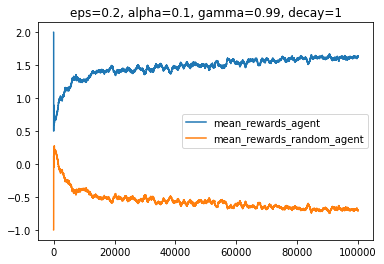

In [ ]:
p1, mean_rewards = experience(T=100001, eps=0.2, alpha=0.1, gamma=0.99, decay=1, window=1000)

In [ ]:
mean_rewards[-1]

In [ ]:
from sympy import Matrix, init_printing
init_printing()

display(Matrix(p1.Q[0].reshape(3,3).T))

⎡1.77287631920522  1.5544913319171   1.94540933118324⎤
⎢                                                    ⎥
⎢1.58509975003736  1.76678902310586  1.62678887085402⎥
⎢                                                    ⎥
⎣1.77550343980685  1.73571607004879  1.76433449305508⎦

In [ ]:
for i in range(3):
    for j in range(3):
        print(f"%.2f   " % p1.Q[0,i+3*j], end ="")
    print("")

1.45   1.54   1.77   
1.61   1.94   1.81   
1.48   1.74   1.79   


In [ ]:
import pandas as pd
print (pd.DataFrame(p1.Q[0].reshape(3,3).T))

          0         1         2
0  1.449176  1.543229  1.773937
1  1.611271  1.935950  1.805189
2  1.480666  1.744596  1.785076


# Alphas Experience

Experience with alpha : 0
Episode: 0 Q[0,0]: 0.0
Episode: 10000 Q[0,0]: 0.0
Episode: 20000 Q[0,0]: 0.0
Episode: 30000 Q[0,0]: 0.0
Episode: 40000 Q[0,0]: 0.0


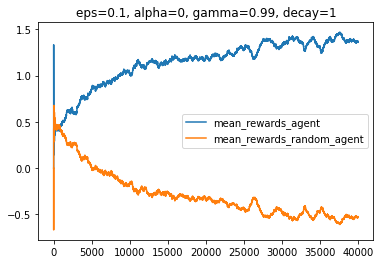

Experience with alpha : 0.1
Episode: 0 Q[0,0]: 0.0
Episode: 10000 Q[0,0]: 0.2764134235604317
Episode: 20000 Q[0,0]: 0.5139430116868022
Episode: 30000 Q[0,0]: 0.6936325014599883
Episode: 40000 Q[0,0]: 0.9290596932662187


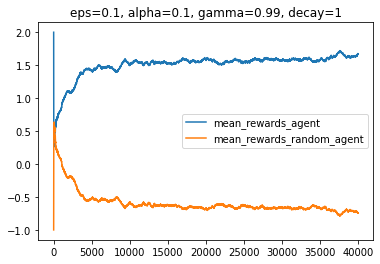

Experience with alpha : 0.3
Episode: 0 Q[0,0]: 0.0
Episode: 10000 Q[0,0]: 0.9988872279904553
Episode: 20000 Q[0,0]: 1.2791765032369515
Episode: 30000 Q[0,0]: 1.712422337225668
Episode: 40000 Q[0,0]: 1.5552969899890625


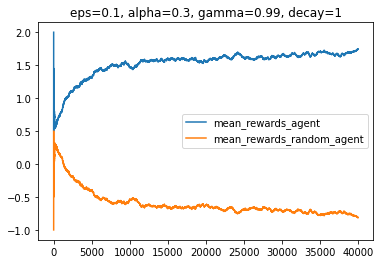

Experience with alpha : 0.5
Episode: 0 Q[0,0]: 0.0
Episode: 10000 Q[0,0]: 1.1577173868449957
Episode: 20000 Q[0,0]: 1.1724552058547895
Episode: 30000 Q[0,0]: 1.5832693363063033
Episode: 40000 Q[0,0]: 1.6844771075183038


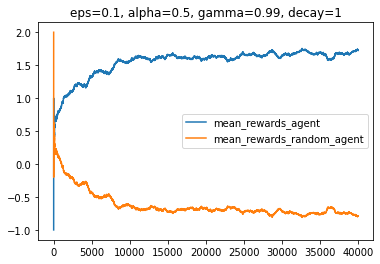

Experience with alpha : 0.7
Episode: 0 Q[0,0]: 0.0
Episode: 10000 Q[0,0]: 1.2611957177275888
Episode: 20000 Q[0,0]: 1.6552019826793039
Episode: 30000 Q[0,0]: 1.6672905974859278
Episode: 40000 Q[0,0]: 1.4075983775952472


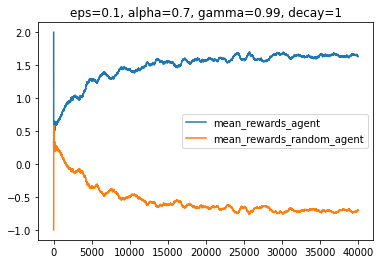

Experience with alpha : 0.9
Episode: 0 Q[0,0]: 0.0
Episode: 10000 Q[0,0]: 0.2238395271375026
Episode: 20000 Q[0,0]: 0.5260482193891012
Episode: 30000 Q[0,0]: 1.91263141949463
Episode: 40000 Q[0,0]: 1.9392427524943872


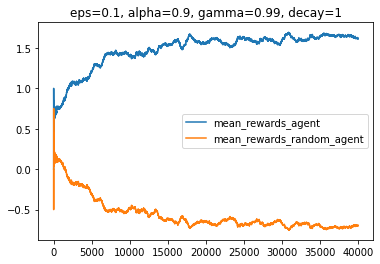

Experience with alpha : 1
Episode: 0 Q[0,0]: 0.0
Episode: 10000 Q[0,0]: 1.9405979999999998
Episode: 20000 Q[0,0]: 1.92119202
Episode: 30000 Q[0,0]: 1.9405979999999998
Episode: 40000 Q[0,0]: 1.9405979999999998


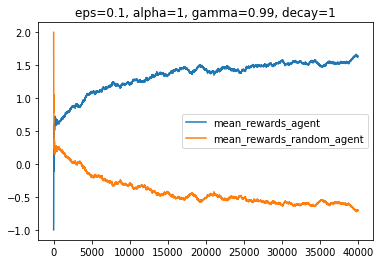

In [ ]:
alphas = [0, 0.1, 0.3,0.5, 0.7, 0.9, 1]
alphas_results = {}

for alpha in alphas:
    print(f"Experience with alpha : {alpha}")
    p1, mean_rewards = experience(T=40001, eps=0.1, alpha=alpha, gamma=0.99, decay=1, window=1000)
    alphas_results[alpha] = mean_rewards



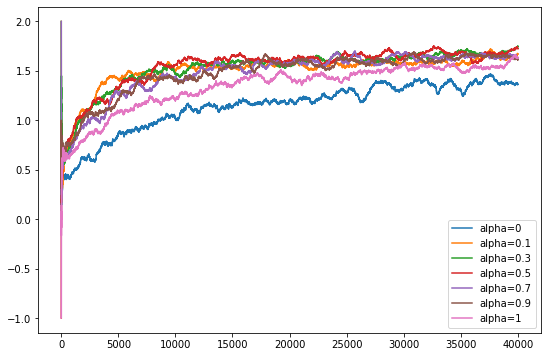

In [ ]:
plt.figure(figsize=(9, 6))
for alpha in alphas:
    rewards = alphas_results[alpha]
    plt.plot(rewards, label=f"alpha={alpha}")
    plt.legend()
plt.show()



In [ ]:
for alpha in alphas:
    rewards = alphas_results[alpha]
    print(alpha, ":", rewards[-1], "mean", np.mean(rewards))

0 : 1.365 mean 1.144082472299359
0.1 : 1.671 mean 1.504690541602828
0.3 : 1.749 mean 1.5279773578604186
0.5 : 1.723 mean 1.5472835029031864
0.7 : 1.63 mean 1.481407021382131
0.9 : 1.614 mean 1.4787525562940733
1 : 1.629 mean 1.3423712214592334


# Gammas Experience

Experience with gamma : 0
Episode: 0 Q[0,0]: 0.0
Episode: 10000 Q[0,0]: 0.0
Episode: 20000 Q[0,0]: 0.0
Episode: 30000 Q[0,0]: 0.0
Episode: 40000 Q[0,0]: 0.0


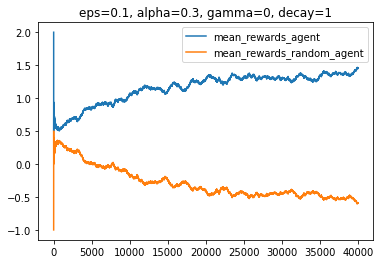

Experience with gamma : 0.3
Episode: 0 Q[0,0]: 0.0
Episode: 10000 Q[0,0]: 0.014416906975839403
Episode: 20000 Q[0,0]: 0.03177918694209151
Episode: 30000 Q[0,0]: 0.03525279509985414
Episode: 40000 Q[0,0]: 0.030735780490541275


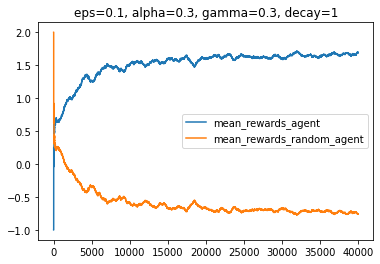

Experience with gamma : 0.5
Episode: 0 Q[0,0]: 0.0
Episode: 10000 Q[0,0]: 0.0967430718916005
Episode: 20000 Q[0,0]: 0.15123275141886872
Episode: 30000 Q[0,0]: 0.16251259933182957
Episode: 40000 Q[0,0]: 0.2614338264077354


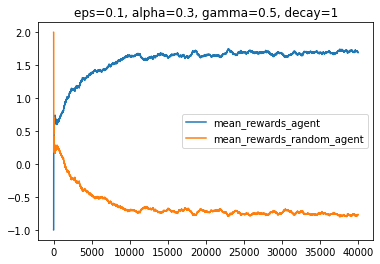

Experience with gamma : 0.9
Episode: 0 Q[0,0]: 0.0
Episode: 10000 Q[0,0]: 1.0224365039494465
Episode: 20000 Q[0,0]: 1.264436203598255
Episode: 30000 Q[0,0]: 0.8754044074547146
Episode: 40000 Q[0,0]: 1.2441560647922714


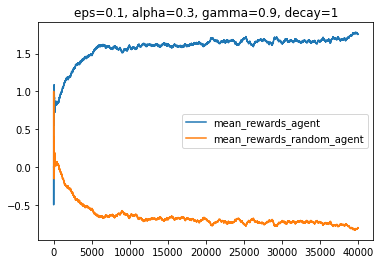

Experience with gamma : 0.95
Episode: 0 Q[0,0]: 0.0
Episode: 10000 Q[0,0]: 1.7088629604548726
Episode: 20000 Q[0,0]: 1.6843335200166731
Episode: 30000 Q[0,0]: 1.790381833989109
Episode: 40000 Q[0,0]: 1.7799914696652561


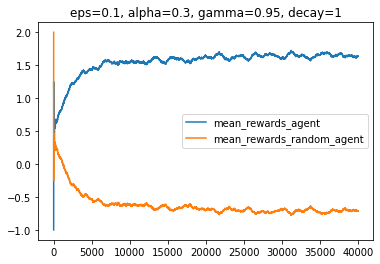

Experience with gamma : 0.99
Episode: 0 Q[0,0]: 0.0
Episode: 10000 Q[0,0]: 0.5198074988804632
Episode: 20000 Q[0,0]: 1.0100175304483952
Episode: 30000 Q[0,0]: 0.8410680600671019
Episode: 40000 Q[0,0]: 1.1254484003933796


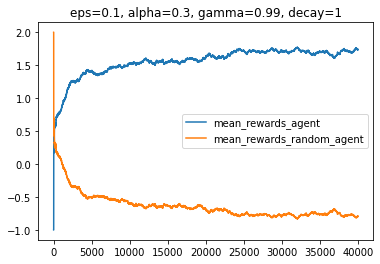

Experience with gamma : 1
Episode: 0 Q[0,0]: 0.0
Episode: 10000 Q[0,0]: 0.8178577217832659
Episode: 20000 Q[0,0]: 1.3759616623921502
Episode: 30000 Q[0,0]: 1.0399908209752302
Episode: 40000 Q[0,0]: 0.963680899632015


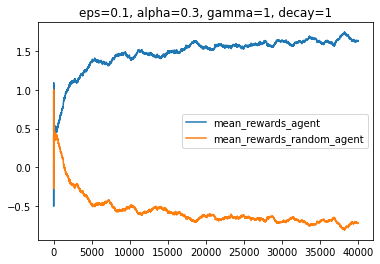

In [ ]:
gammas = [0, 0.3, 0.5, 0.9, 0.95, 0.99, 1]
gammas_results = {}

for gamma in gammas:
    print(f"Experience with gamma : {gamma}")
    p1, mean_rewards = experience(T=40001, eps=0.1, alpha=0.3, gamma=gamma, decay=1, window=1000)
    gammas_results[gamma] = mean_rewards


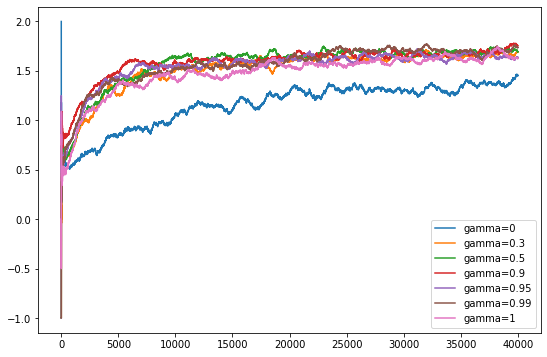

In [ ]:
plt.figure(figsize=(9, 6))
for gamma in gammas:
    rewards = gammas_results[gamma]
    plt.plot(rewards, label=f"gamma={gamma}")
    plt.legend()
plt.show()



In [ ]:
for gamma in gammas:
    rewards = gammas_results[gamma]
    print(gamma, ":", rewards[-1], "mean", np.mean(rewards))

0 : 1.451 mean 1.153486197282359
0.3 : 1.692 mean 1.5140946782257756
0.5 : 1.693 mean 1.5717288109134528
0.9 : 1.755 mean 1.5858452611941865
0.95 : 1.636 mean 1.5453900344047584
0.99 : 1.736 mean 1.556791329854274
1 : 1.625 mean 1.475298618189055


# Policies

Experience with epsilon : 0
Episode: 0 Q[0,0]: 0.0
Episode: 10000 Q[0,0]: 0.37683871365563343
Episode: 20000 Q[0,0]: 0.5743061674601486
Episode: 30000 Q[0,0]: 0.5783987270883951
Episode: 40000 Q[0,0]: 1.0430973103448045


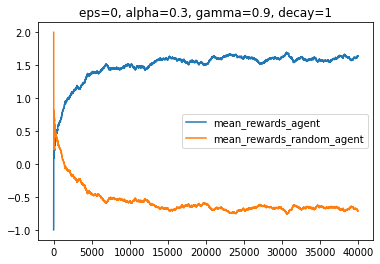

Experience with epsilon : 0.01
Episode: 0 Q[0,0]: 0.0
Episode: 10000 Q[0,0]: 0.4279816145718719
Episode: 20000 Q[0,0]: 0.6899625878788309
Episode: 30000 Q[0,0]: 0.760254601761926
Episode: 40000 Q[0,0]: 1.0007377977579954


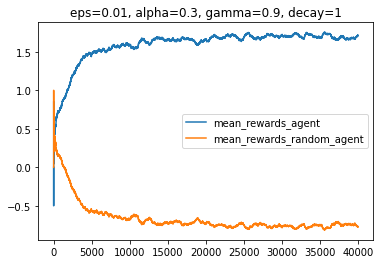

Experience with epsilon : 0.05
Episode: 0 Q[0,0]: 0.0
Episode: 10000 Q[0,0]: 0.6576211586427474
Episode: 20000 Q[0,0]: 0.7739566494353921
Episode: 30000 Q[0,0]: 0.8076478687445966
Episode: 40000 Q[0,0]: 1.1021456863463928


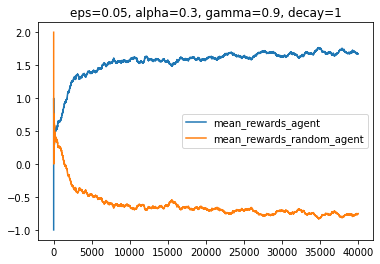

Experience with epsilon : 0.1
Episode: 0 Q[0,0]: 0.0
Episode: 10000 Q[0,0]: 0.7698621168278622
Episode: 20000 Q[0,0]: 0.8940974452348138
Episode: 30000 Q[0,0]: 0.7812086434124491
Episode: 40000 Q[0,0]: 1.0613076806976955


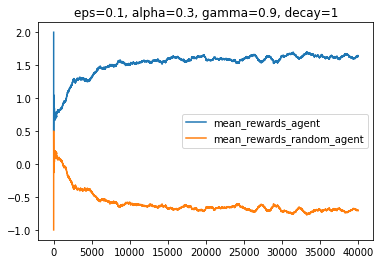

Experience with epsilon : 0.3
Episode: 0 Q[0,0]: 0.0
Episode: 10000 Q[0,0]: 0.9552291414476493
Episode: 20000 Q[0,0]: 1.3746270812409986
Episode: 30000 Q[0,0]: 1.3736847550764515
Episode: 40000 Q[0,0]: 1.5360962511616039


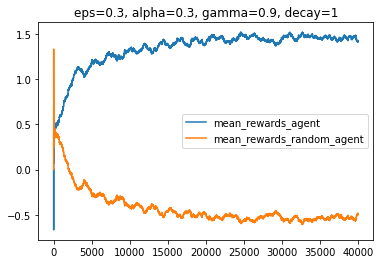

Experience with epsilon : 0.5
Episode: 0 Q[0,0]: 0.0
Episode: 10000 Q[0,0]: 1.2709389596281395
Episode: 20000 Q[0,0]: 1.5109410883818204
Episode: 30000 Q[0,0]: 1.480503549685115
Episode: 40000 Q[0,0]: 1.4567687650968277


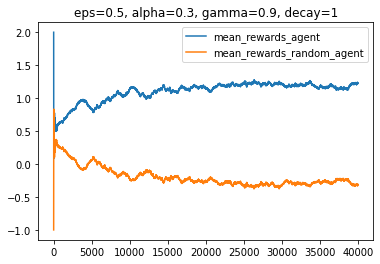

Experience with epsilon : 0.8
Episode: 0 Q[0,0]: 0.0
Episode: 10000 Q[0,0]: 1.245220128094557
Episode: 20000 Q[0,0]: 1.489027012389001
Episode: 30000 Q[0,0]: 1.5364641723509367
Episode: 40000 Q[0,0]: 1.6039948622888534


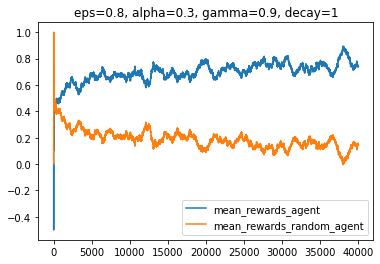

Experience with epsilon : 1
Episode: 0 Q[0,0]: 0.0
Episode: 10000 Q[0,0]: 1.2994319149148679
Episode: 20000 Q[0,0]: 1.5887091540940506
Episode: 30000 Q[0,0]: 1.593393832043062
Episode: 40000 Q[0,0]: 1.6096245855860667


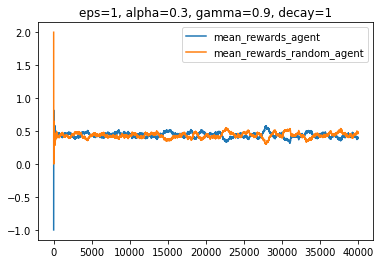

In [ ]:
epsilons = [0, 0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1]
epsilons_agents = {}

for epsilon in epsilons:
    print(f"Experience with epsilon : {epsilon}")
    p1, mean_rewards = experience(T=40001, eps=epsilon, alpha=0.3, gamma=0.9, decay=1, window=1000)
    epsilons_agents[epsilon] = p1


In [ ]:
# test_agent_optimal_game(p1, p2, env, draw=False) -> reward1, reward2
def agent_optimal_game_reward(p1, T=1000):
    rewards = []
    for _ in range(T):

        env = TicTacToe()
        p2 = RandomAgent()
        p1.set_symbol(env.x)
        p2.set_symbol(env.o)
        r1, r2 = test_agent_optimal_game(p1, p2, env)
        rewards.append(r1)


        env = TicTacToe()
        p2 = RandomAgent()
        p1.set_symbol(env.x)
        p2.set_symbol(env.o)
        r2, r1 = test_agent_optimal_game(p2,p1, env)
        rewards.append(r1)
    
    print(f"Mean rewards after {2*T} game:", np.mean(rewards))

    return rewards


In [ ]:
epsilon = 0.1
rewards = agent_optimal_game_reward(epsilons_agents[epsilon])

Mean rewards after 2000 game: 1.7925


In [ ]:
epsilons_results = {}
for epsilon in epsilons:
    print("Experience for epsilon = ", epsilon)
    rewards = agent_optimal_game_reward(epsilons_agents[epsilon])
    epsilons_results[epsilon] = np.mean(rewards)

Experience for epsilon =  0
Mean rewards after 2000 game: 1.817
Experience for epsilon =  0.01
Mean rewards after 2000 game: 1.904
Experience for epsilon =  0.05
Mean rewards after 2000 game: 1.882
Experience for epsilon =  0.1
Mean rewards after 2000 game: 1.776
Experience for epsilon =  0.3
Mean rewards after 2000 game: 1.8795
Experience for epsilon =  0.5
Mean rewards after 2000 game: 1.872
Experience for epsilon =  0.8
Mean rewards after 2000 game: 1.8635
Experience for epsilon =  1
Mean rewards after 2000 game: 1.778


In [ ]:
plt.figure(figsize=(9, 6))
for epsilon in epsilons:
    rewards = epsilons_results[epsilon]
    plt.plot(rewards, label=f"epsilon={epsilon}")
    plt.legend()
plt.show()



In [ ]:
for epsilon in epsilons:
    rewards = epsilons_results[epsilon]
    print(epsilon, ":", rewards[-1], ", training mean: ", np.mean(rewards))

## Optimal Values Experience

Episode: 0 Q[0,0]: 0.0
Episode: 10000 Q[0,0]: 1.4058311808738846
Episode: 20000 Q[0,0]: 1.4378474830031516
Episode: 30000 Q[0,0]: 1.542000675529308
Episode: 40000 Q[0,0]: 1.5888287022959349
Episode: 50000 Q[0,0]: 1.5401210015930742
Episode: 60000 Q[0,0]: 1.5799709367718628
Episode: 70000 Q[0,0]: 1.58675362008215
Episode: 80000 Q[0,0]: 1.5547861034221306
Episode: 90000 Q[0,0]: 1.5792943892180158
Episode: 100000 Q[0,0]: 1.5732218242833107


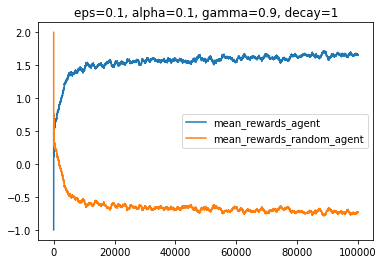

In [17]:
p1, mean_rewards = experience(T=100001, eps=0.1, alpha=0.1, gamma=0.9, decay=1, window=1000)

### Q-values at the start of the game

In [ ]:
for i in range(LENGTH):
    print("----------------------")
    for j in range(LENGTH):
        #print(" ", end='')
        if j == 0:
            print(f"| %.2f |" % p1.Q[0, i], end='')
        else:
            print(f" %.2f |" % p1.Q[0, i+3*j], end='')
    print("")
print("----------------------")

----------------------
| 1.11 | 1.00 | 1.59 |
----------------------
| 0.80 | 1.26 | 0.99 |
----------------------
| 1.13 | 1.01 | 1.10 |
----------------------


In [ ]:
display(Matrix(p1.Q[0].reshape(3,3).T))

⎡1.59672975954505   1.12298554636368   1.14359342927389 ⎤
⎢                                                       ⎥
⎢0.915654497404132  1.14674895510695   0.550447104419326⎥
⎢                                                       ⎥
⎣1.01674501882697   0.626385415699457  1.48679172784529 ⎦

# Playing vs Trained agent 

In [18]:
def play_vs_agent():
    env = TicTacToe()
    human = Human()
    human.set_symbol(env.o)

    while True:
        #p1.set_verbose(True)
        play_game_vs_human(p1,human, TicTacToe(), draw=2)
        # I made human player 1 to see if it would
        # select center to start with
        answer = input("Play again? [Y/n]:")
        if answer and answer.lower()[0] == "n":
            break


Episode: 0 Q[0,0]: 0.0
Episode: 10000 Q[0,0]: 0.8159458139205893
Episode: 20000 Q[0,0]: 1.3031338944850956
Episode: 30000 Q[0,0]: 1.0482457558311402
Episode: 40000 Q[0,0]: 1.363607358382294
Episode: 50000 Q[0,0]: 0.7387109195061263


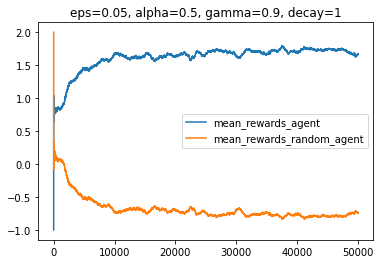

In [ ]:
p1, mean_rewards = experience(T=50001, eps=0.1, alpha=0.1, gamma=0.9, decay=1, window=1000)

In [ ]:
for i in range(3):
    for j in range(3):
        print(f"%.2f   " % p1.Q[0,i+3*j], end ="")
    print("")

1.57   1.45   1.59   
1.45   1.60   1.58   
1.57   1.59   1.59   


In [19]:
play_vs_agent()

-------------
| x |   |   |
-------------
|   |   |   |
-------------
|   |   |   |
-------------
Enter the coordinates i,j for your next move (i,j=0..2)1,1
-------------
| x | x |   |
-------------
|   | o |   |
-------------
|   |   |   |
-------------
Enter the coordinates i,j for your next move (i,j=0..2)0,2
-------------
| x | x | o |
-------------
|   | o |   |
-------------
| x |   |   |
-------------
Enter the coordinates i,j for your next move (i,j=0..2)1,0
-------------
| x | x | o |
-------------
| o | o | x |
-------------
| x |   |   |
-------------
Enter the coordinates i,j for your next move (i,j=0..2)2,2
-------------
| x | x | o |
-------------
| o | o | x |
-------------
| x | x | o |
-------------
Play again? [Y/n]:
-------------
| x |   |   |
-------------
|   |   |   |
-------------
|   |   |   |
-------------
Enter the coordinates i,j for your next move (i,j=0..2)2,2
-------------
| x |   |   |
-------------
|   |   |   |
-------------
| x |   | o |
-------------
